In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((128, 2), load_parcel=True, load_allen=True)

[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

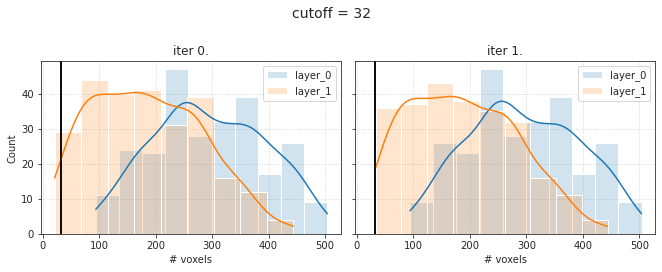

[PROGRESS] merge: done

[PROGRESS] erode: done

num regions,    left: 254,  right: 254
region id diff,         r - l:  Counter({256: 254})

[PROGRESS] fit columnar: done

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*2

[PROGRESS] save results: done.

In [3]:
# mice.parcel.fit_parcel(True, cutoff=4)

In [3]:
%%time
_ = mice.setup_dfs(mode='ca2', task='rest')
_ = mice.setup_dfs(mode='bold', task='rest')

CPU times: user 157 ms, sys: 6.44 s, total: 6.6 s
Wall time: 8.11 s


In [4]:
%%time

import ants

top2d = 'parcel2d-top_10um.nii.gz'
top2d = pjoin(mice.cfg.main_dir, top2d)
top2d = ants.image_read(top2d, pixeltype='unsigned int')
top2d = top2d.numpy()

flat2d = 'parcel2d-flat_10um.nii.gz'
flat2d = pjoin(mice.cfg.main_dir, flat2d)
flat2d = ants.image_read(flat2d, pixeltype='unsigned int')
flat2d = flat2d.numpy()

#parcel3d = 'parcel3d_10um.nii.gz'
#parcel3d = pjoin(mice.cfg.main_dir, parcel3d)
#parcel3d = ants.image_read(parcel3d, pixeltype='unsigned int')
#parcel3d = parcel3d.numpy()

topview = 'topview_10um.nii.gz'
topview = pjoin(mice.cfg.base_dir, topview)
topview = ants.image_read(topview, pixeltype='unsigned int')
topview = topview.numpy()

flatmap = 'flatmap_10um.nii.gz'
flatmap = pjoin(mice.cfg.base_dir, flatmap)
flatmap = ants.image_read(flatmap, pixeltype='unsigned int')
flatmap = flatmap.numpy()

CPU times: user 188 ms, sys: 39.7 ms, total: 228 ms
Wall time: 249 ms


In [5]:
list(mice.parcel.results)

[
    'cortex',
    'cortex-top',
    'cortex-raw',
    'cortex-eroded',
    'cortex-regions',
    'merged-regions',
    'top-regions',
    'merged-ids',
    'radius',
    'cutoff',
    'nonzero-idxs_parcel2d-flat',
    'nonzero-idxs_parcel2d-top',
    'nonzero-idxs_parcel3d',
    'region-idxs_parcel2d-flat',
    'region-idxs_parcel2d-top',
    'region-idxs_parcel3d',
    'shape_parcel2d-flat',
    'shape_parcel2d-top',
    'shape_parcel3d',
    'subcortex',
    'subcortex-l',
    'subcortex-r',
    'major_masks',
    'major_colors',
    'cmap'
]

In [6]:
sv = SVINET(mice, 6, 15, mode='ca2').load_results()

current expt: 'p15'

[PROGRESS] loading 'k6-real-euclidean-linksampling-(2021_10_16)' from
'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*2/results/SVINET/n-
128*2_ca2_rest_pearson_sub-SLC/p15'

[PROGRESS] process results: done

[PROGRESS] 0 results loaded

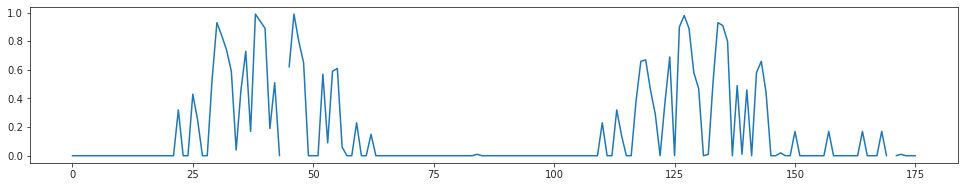

In [7]:
fig, ax = create_figure(1, 1, (13.5, 2.7))
ax.plot(np.round(sv.pi, 2)[2]);

In [8]:
valid_regions = [
    mice.parcel.encode(lbl)
    for lbl in sv.l2n
]

In [9]:
def project_pi(pi, min_thres: float = 0.01, items: List[str] = None):
    items = items if items else [
        'parcel2d-top',
        'parcel2d-flat',
        'parcel3d',
    ]
    dense = {
        name: np.zeros(
            (len(pi), *mice.parcel.results[f"shape_{name}"]), dtype=float)
        for name in items
    }
    for oc_idx, data in tqdm(enumerate(pi), total=len(pi)):
        for node, lbl in sv.n2l.items():
            if data[node] < min_thres:
                continue
            ii = mice.parcel.encode(lbl)
            for name, arr in dense.items():
                if ii in mice.parcel.results[f"region-idxs_{name}"]:
                    ids = mice.parcel.results[f"region-idxs_{name}"][ii]
                    ids = mice.parcel.results[f"nonzero-idxs_{name}"][ids]
                    arr[oc_idx].flat[ids] = data[node]
    return dense

In [10]:
%%time

min_thres = 0.01
dense = project_pi(np.round(sv.pi, 2), min_thres, ['parcel2d-top', 'parcel2d-flat'])

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 130 ms, sys: 21.8 ms, total: 152 ms
Wall time: 149 ms


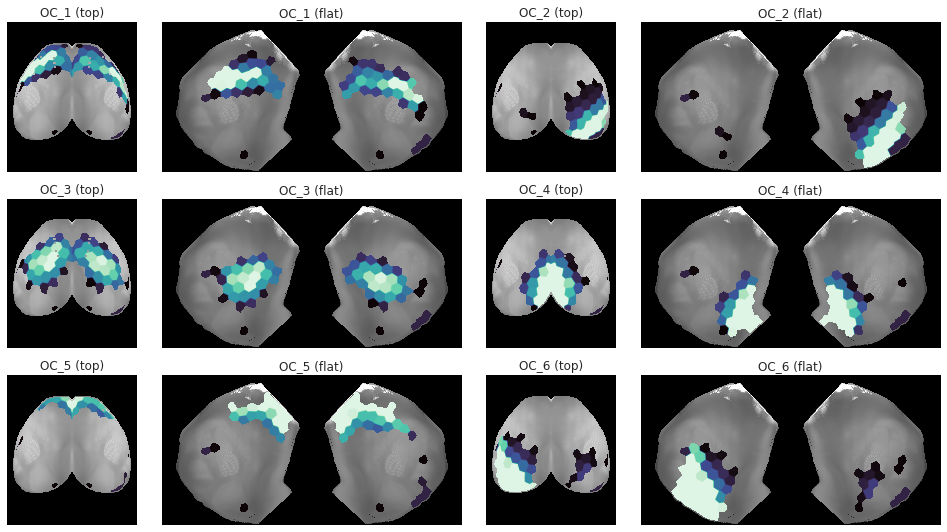

In [11]:
ncols = 4
nrows = int(np.ceil(len(sv.pi) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})


for i in range(len(sv.pi)):
    data_top = dense['parcel2d-top'][i]
    data_flat = dense['parcel2d-flat'][i]
        
    cond = ~np.isin(top2d, valid_regions)
    cond = np.logical_or(cond, data_top < min_thres)
    data2plt = np.ma.masked_where(cond, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap='mako', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (top)")

    cond = ~np.isin(flat2d, valid_regions)
    cond = np.logical_or(cond, data_flat < min_thres)
    data2plt = np.ma.masked_where(cond, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap='mako', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (flat)")

remove_ticks(axes)
plt.show()

In [12]:
fig.savefig(pjoin(tmp_dir, 'ca2_mega-animal_k6.pdf'), bbox_inches='tight')

In [13]:
sv = SVINET(mice, 8, 15, mode='bold').load_results()

current expt: 'p15'

[PROGRESS] loading 'k8-real-euclidean-linksampling-(2021_10_16)' from
'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*2/results/SVINET/n-
128*2_bold_rest_pearson_sub-SLC/p15'

[PROGRESS] process results: done

[PROGRESS] 0 results loaded

In [14]:
valid_regions = [
    mice.parcel.encode(lbl)
    for lbl in sv.l2n
]

In [15]:
%%time

min_thres = 0.01
dense = project_pi(np.round(sv.pi, 2), min_thres)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 10.2 s, sys: 5.98 s, total: 16.2 s
Wall time: 16.2 s


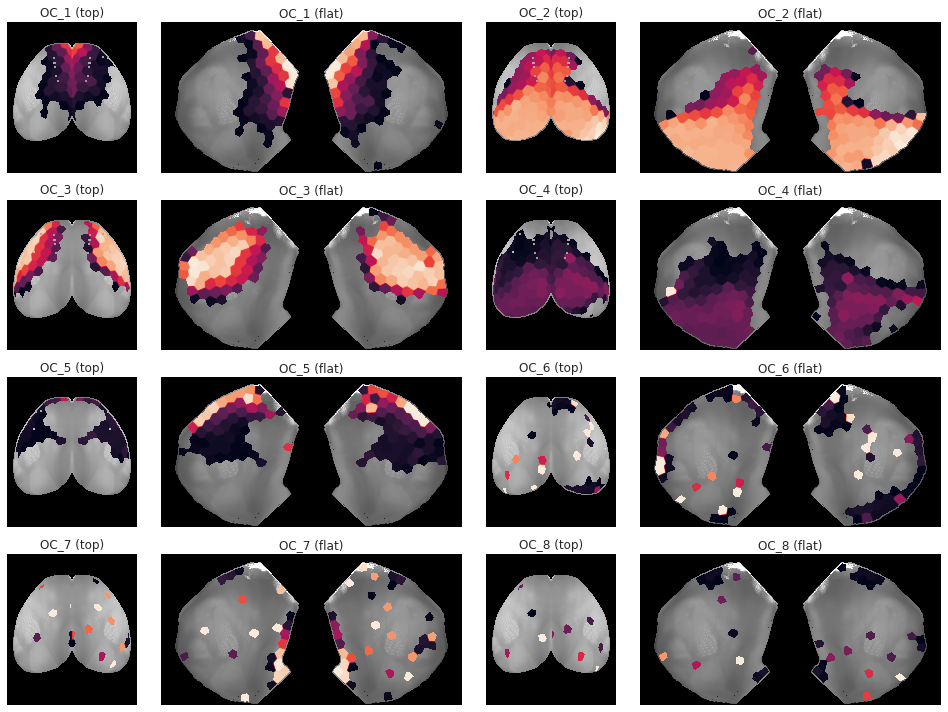

In [16]:
ncols = 4
nrows = int(np.ceil(len(sv.pi) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

for i in range(len(sv.pi)):
    data_top = dense['parcel2d-top'][i]
    data_flat = dense['parcel2d-flat'][i]
    
    cond = ~np.isin(top2d, valid_regions)
    cond = np.logical_or(cond, data_top < min_thres)
    data2plt = np.ma.masked_where(cond, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (top)")

    cond = ~np.isin(flat2d, valid_regions)
    cond = np.logical_or(cond, data_flat < min_thres)
    data2plt = np.ma.masked_where(cond, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (flat)")
remove_ticks(axes)
plt.show()

In [17]:
dense['parcel3d'].shape

(8, 1320, 800, 1140)

<matplotlib.image.AxesImage object at 0x7f72edbcbd60>

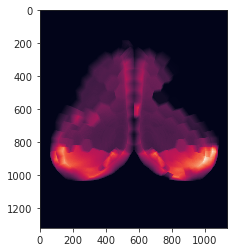

In [20]:
plt.imshow(dense['parcel3d'][1].mean(1))

<matplotlib.image.AxesImage object at 0x7f72edbaf070>

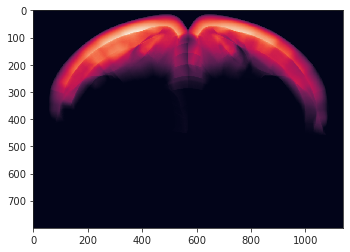

In [21]:
plt.imshow(dense['parcel3d'][1].mean(0))

  0%|          | 0/8 [00:00<?, ?it/s]

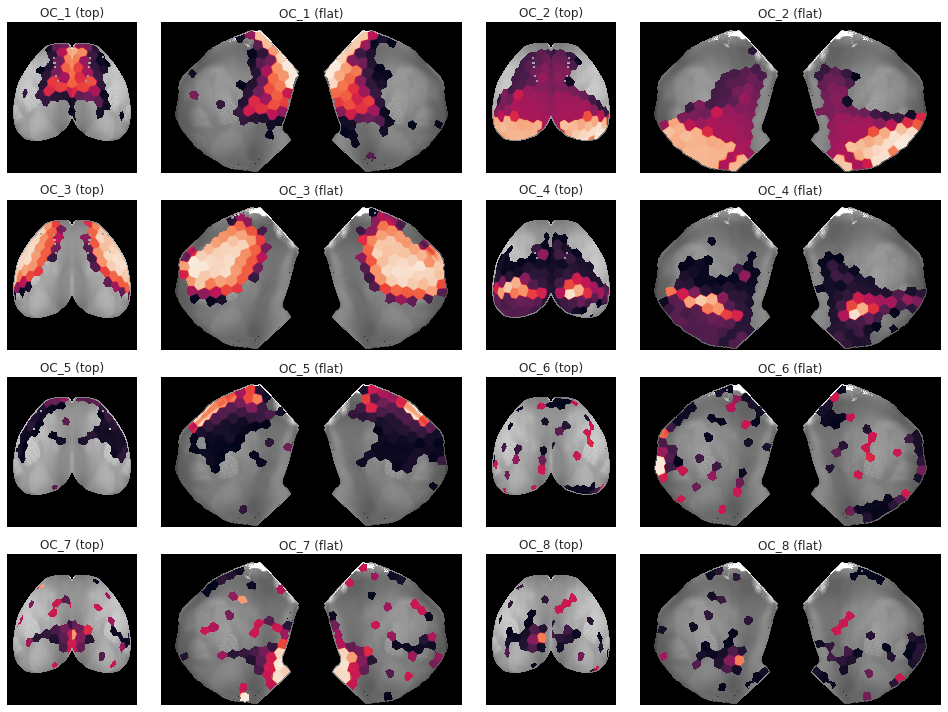

In [22]:
ncols = 4
nrows = int(np.ceil(len(sv.pi) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

for i in tqdm(range(len(sv.pi))):
    vol2top = mice.al.cortical_map(dense['parcel3d'][i], 'top_view', np.mean)
    vol2flat = mice.al.cortical_map(dense['parcel3d'][i], 'dorsal_flatmap', np.mean)

    cond = ~np.isin(top2d, valid_regions)
    cond = np.logical_or(cond, vol2top < min_thres)
    data2plt = np.ma.masked_where(cond, vol2top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (top)")

    cond = ~np.isin(flat2d, valid_regions)
    cond = np.logical_or(cond, vol2flat < min_thres)
    data2plt = np.ma.masked_where(cond, vol2flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (flat)")
remove_ticks(axes)
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

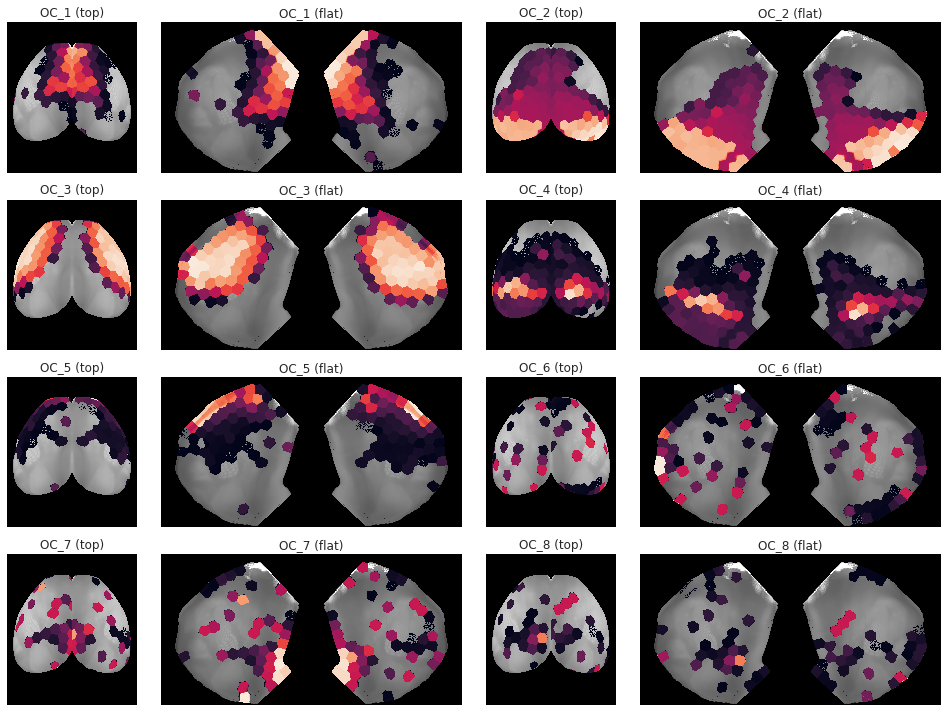

<matplotlib.colorbar.Colorbar object at 0x7f31e83767c0>

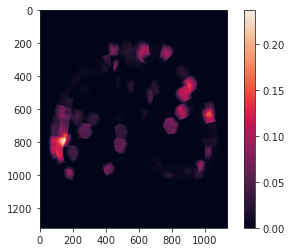

In [58]:
plt.imshow(.mean(1))
plt.colorbar()

[<matplotlib.lines.Line2D object at 0x7f31e869fb20>]

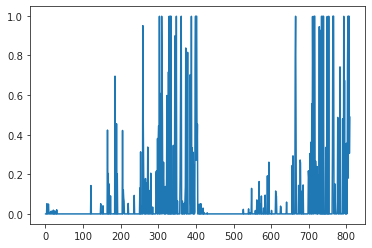

In [53]:
plt.plot(sv.pi[7])

In [91]:
min_thres = 0.1

  0%|          | 0/8 [00:00<?, ?it/s]

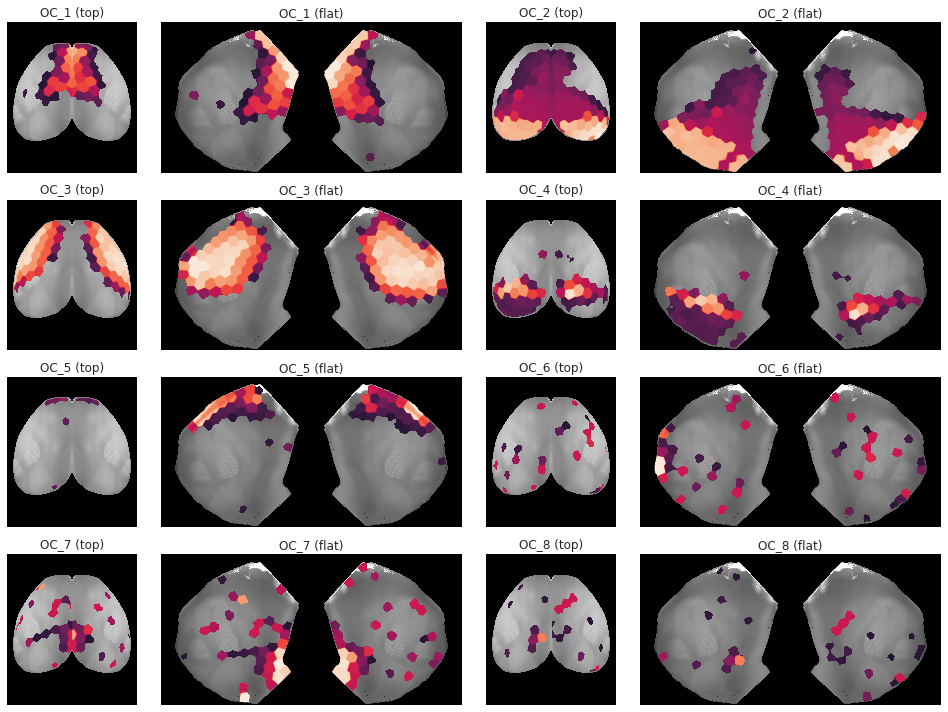

In [92]:
ncols = 4
nrows = int(np.ceil(len(sv.pi) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

for i in tqdm(range(len(sv.pi))):
    vol2top = mice.al.cortical_map(dense['parcel3d'][i], 'top_view', np.mean)
    vol2flat = mice.al.cortical_map(dense['parcel3d'][i], 'dorsal_flatmap', np.mean)

    smoothed = ndimage.gaussian_filter(vol2top, sigma=2)
    data2plt = np.ma.masked_where(smoothed < min_thres, vol2top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (top)")

    smoothed = ndimage.gaussian_filter(vol2flat, sigma=5)
    data2plt = np.ma.masked_where(smoothed < min_thres, vol2flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket', interpolation='antialiased')
    ax.set_title(f"OC_{i+1} (flat)")
remove_ticks(axes)
plt.show()

In [94]:
fig.savefig(pjoin(tmp_dir, 'bold_mega-animal_k8.pdf'), bbox_inches='tight')

[<matplotlib.lines.Line2D object at 0x7f7521e8ba00>]

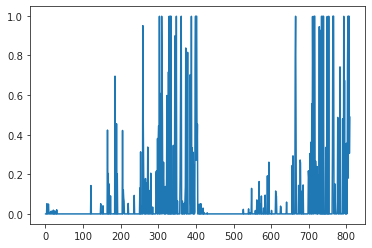

In [103]:
plt.plot(sv.pi[-1])

In [107]:
cortex_nodes = [node for node, lbl in sv.n2l.items() if len(lbl.split('-')) == 3]
subcortex_nodes = [node for node, lbl in sv.n2l.items() if len(lbl.split('-')) == 2]

[<matplotlib.lines.Line2D object at 0x7f7521bc90a0>]

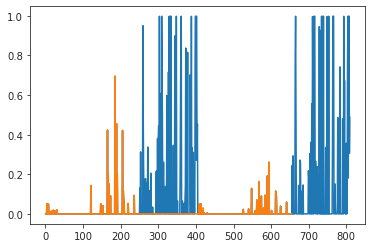

In [111]:
plt.plot(sv.pi[-1])
plt.plot(cortex_nodes, sv.pi[-1][cortex_nodes])

In [112]:
np.argmax(sv.pi[-1][cortex_nodes])

185

In [114]:
sv.pi[-1][cortex_nodes[185]]

0.6953683493331805

In [119]:
sv.n2l[cortex_nodes[185]]

'1-94-1'

In [116]:
from register.atlas import Allen
al10 = Allen(10)

In [118]:
sns.histplot(dense['parcel3d'][-1][al10.get_masks('Isocortex')])

KeyboardInterrupt: 

<matplotlib.colorbar.Colorbar object at 0x7f7521f094c0>

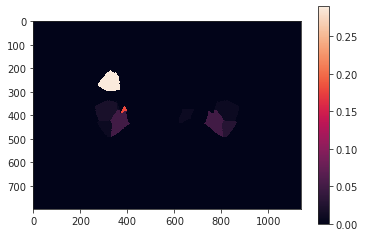

In [101]:
plt.imshow(dense['parcel3d'][-1][300])
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f7522abb4c0>

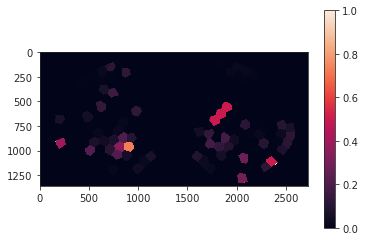

In [97]:
plt.imshow(vol2flat, vmin=0, vmax=1)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f91b0b2b070>

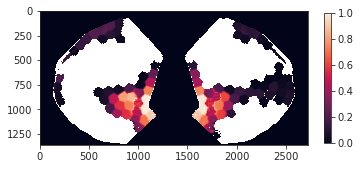

In [194]:
plt.imshow(vol2flat)
plt.colorbar(shrink=0.6)

<matplotlib.image.AxesImage object at 0x7f91b09ba250>

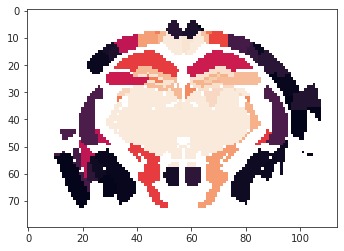

In [198]:
plt.imshow(data_vol[70])

In [ ]:
ncols = 2 * 2
nrows = 2 * int(np.ceil(len(sv.pi) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

min_thres = 0.01

for i, data in enumerate(sv.pi):
    data_top = np.zeros_like(top2d).astype(float)
    data_flat = np.zeros_like(flat2d).astype(float)
    for node, lbl in sv.n2l.items():
        ii = mice.parcel.encode(lbl)
        data_top[top2d == ii] = data[node]
        data_flat[flat2d == ii] = data[node]
    
    cond = ~np.isin(top2d, valid_regions)
    cond = np.logical_or(cond, data_top < min_thres)
    data2plt = np.ma.masked_where(cond, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket')
    ax.set_title(f"OC_{i+1} (top)")

    cond = ~np.isin(flat2d, valid_regions)
    cond = np.logical_or(cond, data_flat < min_thres)
    data2plt = np.ma.masked_where(cond, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap='rocket')
    ax.set_title(f"OC_{i+1} (flat)")
remove_ticks(axes)
plt.show()

In [ ]:
masks_fx = self.mice.al.fuse_masks(self.struct_ids)

In [3]:
from register.register import Register
reg = Register(mice)

In [4]:
reg.organize_func(0.1)

logger 'organize_func_(2021_10_12).log' created at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-768*4/log

Name: cortex-merged . . . a total of 1020 regions were accepted.
accept ratio: 72 %, reject ratio: 28 %, using a presence threshold of 10.0 %

organizing ca2:  sub-SLC10_ses-3_run-7: 100%|██████████| 210/210 [1:37:44<00:00, 27.92s/it]


Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

Name: subcortex-l . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

Name: subcortex-r . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

organizing bold:  sub-SLC10_ses-3_run-7: 100%|██████████| 210/210 [1:18:37<00:00, 22.47s/it]


In [12]:
reg.set_mode('3d')
acc = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc.items()}

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

Name: subcortex-l . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

Name: subcortex-r . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

{'cortex-merged': 5368, 'subcortex-l': 154, 'subcortex-r': 154, 'subcortex': 154}

In [13]:
cor3d = acc['cortex-merged']

In [14]:
reg.set_mode('2d')
acc2 = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc2.items()}

cor2d = acc2['cortex-merged']

Name: cortex-merged . . . a total of 1020 regions were accepted.
accept ratio: 72 %, reject ratio: 28 %, using a presence threshold of 10.0 %

In [15]:
[i for i in cor2d if i not in cor3d]

[]

In [26]:
thres = 0.1

regions_all = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        mask = mice.mask3d[key].load_ants('unsigned int')
        mask = mask.numpy().astype(bool)
        obj = reg.load_obj_masks(key)
        x = obj['cortex-merged'].numpy()
        x *= mask
        regions = np.unique(x[x.nonzero()])
        regions_all[key] = sorted(regions)

regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {
    i: v / len(regions_all)
    for i, v in freq.items()
}
freq = {
    i: freq.get(i, 0.0) for i in
    mice.parcel.complement(list(freq))
}

rej = dict(filter(
    lambda t: t[1] < thres,
    freq.items()
))
rej = mice.parcel.complement(sorted(rej))
acc = [
    i for i in freq
    if i not in rej
]

msg = '\n\n'
msg += f"Name: {'cortex-merged'} . . . a total of {len(acc)} regions were accepted.\n"
msg += f"accept ratio: {100 * len(acc) / len(freq):0.0f} %, "
msg += f"reject ratio: {100 * len(rej) / len(freq):0.0f} %, "
msg += f"using a presence threshold of {0.1 * 100} %\n"

print(msg)

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

<AxesSubplot:ylabel='Proportion'>

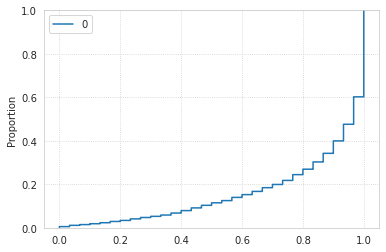

In [12]:
sns.ecdfplot(freq.values())

In [4]:

list(obj)

['cortex-merged', 'subcortex-l', 'subcortex-r', 'CH']

array([   1,    2,    3, ..., 6074, 6079, 6098], dtype=uint32)

In [ ]:
regions_all = {}


[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

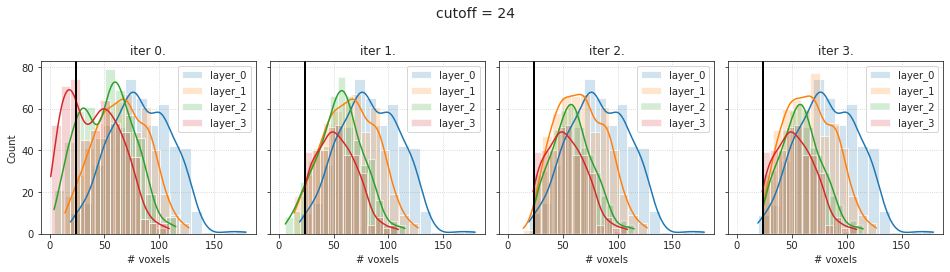

[PROGRESS] merge: done

Warning, region '163' is flat

Warning, region '178' is flat

Warning, region '193' is flat

[PROGRESS] erode: done

num merged regions,     left: 923,  right: 923
region id diff,         r - l:  Counter({1024: 923})

[PROGRESS] fit columnar: done

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*4

[PROGRESS] save results: done.

In [3]:
mice.parcel.fit_parcel(True, cutoff=3)

In [4]:
from register.register import Register
reg = Register(mice)

In [5]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [14:13<00:00, 28.44s/it]


In [6]:
reg.organize_func()

organizing bold:  sub-SLC01_ses-2_run-1:   3%|▎         | 7/210 [01:39<46:21, 13.70s/it]  /home/hadi/Dropbox/git/_Ca-fMRI/register/register.py:827: RuntimeWarning:

Mean of empty slice.

/home/hadi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning:

invalid value encountered in true_divide



Warnin! doing sub-SLC01_ses-2_run-1, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-2:   4%|▍         | 8/210 [01:53<45:49, 13.61s/it]

Warnin! doing sub-SLC01_ses-2_run-2, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-3:   4%|▍         | 9/210 [02:06<45:16, 13.51s/it]

Warnin! doing sub-SLC01_ses-2_run-3, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-4:   5%|▍         | 10/210 [02:20<45:01, 13.51s/it]

Warnin! doing sub-SLC01_ses-2_run-4, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-5:   5%|▌         | 11/210 [02:32<44:00, 13.27s/it]

Warnin! doing sub-SLC01_ses-2_run-5, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-6:   6%|▌         | 12/210 [02:45<43:37, 13.22s/it]

Warnin! doing sub-SLC01_ses-2_run-6, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-7:   6%|▌         | 13/210 [02:58<42:50, 13.05s/it]

Warnin! doing sub-SLC01_ses-2_run-7, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC04_ses-2_run-1:  33%|███▎      | 70/210 [13:11<30:54, 13.25s/it]

Warnin! doing sub-SLC04_ses-2_run-1, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-2:  34%|███▍      | 71/210 [13:24<30:42, 13.26s/it]

Warnin! doing sub-SLC04_ses-2_run-2, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-3:  34%|███▍      | 72/210 [13:37<30:24, 13.22s/it]

Warnin! doing sub-SLC04_ses-2_run-3, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-4:  35%|███▍      | 73/210 [13:50<30:08, 13.20s/it]

Warnin! doing sub-SLC04_ses-2_run-4, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-5:  35%|███▌      | 74/210 [14:03<29:47, 13.14s/it]

Warnin! doing sub-SLC04_ses-2_run-5, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-6:  36%|███▌      | 75/210 [14:16<29:36, 13.16s/it]

Warnin! doing sub-SLC04_ses-2_run-6, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-7:  36%|███▌      | 76/210 [14:30<29:29, 13.20s/it]

Warnin! doing sub-SLC04_ses-2_run-7, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC07_ses-3_run-1:  67%|██████▋   | 140/210 [29:10<16:26, 14.09s/it]

Warnin! doing sub-SLC07_ses-3_run-1, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-2:  67%|██████▋   | 141/210 [29:24<16:10, 14.06s/it]

Warnin! doing sub-SLC07_ses-3_run-2, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-3:  68%|██████▊   | 142/210 [29:37<15:36, 13.77s/it]

Warnin! doing sub-SLC07_ses-3_run-3, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-4:  68%|██████▊   | 143/210 [29:50<15:19, 13.72s/it]

Warnin! doing sub-SLC07_ses-3_run-4, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-5:  69%|██████▊   | 144/210 [30:05<15:17, 13.90s/it]

Warnin! doing sub-SLC07_ses-3_run-5, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-6:  69%|██████▉   | 145/210 [30:20<15:24, 14.22s/it]

Warnin! doing sub-SLC07_ses-3_run-6, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-7:  70%|██████▉   | 146/210 [30:35<15:27, 14.49s/it]

Warnin! doing sub-SLC07_ses-3_run-7, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC08_ses-1_run-1:  70%|███████   | 147/210 [30:49<15:02, 14.33s/it]

Warnin! doing sub-SLC08_ses-1_run-1, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-2:  70%|███████   | 148/210 [31:03<14:38, 14.17s/it]

Warnin! doing sub-SLC08_ses-1_run-2, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-3:  71%|███████   | 149/210 [31:17<14:33, 14.32s/it]

Warnin! doing sub-SLC08_ses-1_run-3, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-4:  71%|███████▏  | 150/210 [31:32<14:29, 14.49s/it]

Warnin! doing sub-SLC08_ses-1_run-4, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-5:  72%|███████▏  | 151/210 [31:46<14:05, 14.33s/it]

Warnin! doing sub-SLC08_ses-1_run-5, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-6:  72%|███████▏  | 152/210 [31:59<13:23, 13.86s/it]

Warnin! doing sub-SLC08_ses-1_run-6, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC10_ses-3_run-7: 100%|██████████| 210/210 [45:30<00:00, 13.00s/it]


In [3]:
path = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates'
sorted(os.listdir(path))

[
    'dorsal_flatmap_paths_10.h5',
    'isocortex_boundary_10.nrrd',
    'laplacian_10.nrrd',
    'top_view_paths_10.h5'
]

In [5]:
laplacian, laplacian_header = nrrd.read(pjoin(path, 'laplacian_10.nrrd'))

In [6]:
laplacian.shape

(1320, 800, 1140)

In [7]:
laplacian_header

OrderedDict([('type', 'float'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([1320,  800, 1140])), ('space directions', array([[10.,  0.,  0.],
       [ 0., 10.,  0.],
       [ 0.,  0., 10.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])

<matplotlib.image.AxesImage object at 0x7f3297ac18b0>

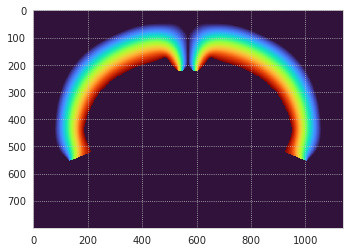

In [10]:
plt.imshow(laplacian[600], cmap='turbo')

In [11]:
boundary, boundary_header = nrrd.read(pjoin(path, 'isocortex_boundary_10.nrrd'))

In [22]:
import h5py

In [45]:
with h5py.File(pjoin(path, 'top_view_paths_10.h5'), 'r') as f:
    paths = np.array(f['paths'])
    view = np.array(f['view lookup'])
paths.shape, view.shape

((713732, 200), (1320, 1140))

<matplotlib.colorbar.Colorbar object at 0x7f3296611790>

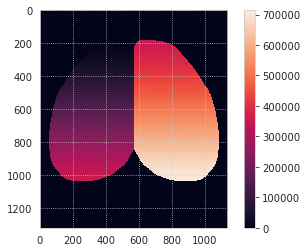

In [53]:
plt.imshow(view)
plt.colorbar()

In [51]:
with h5py.File(pjoin(path, 'dorsal_flatmap_paths_10.h5'), 'r') as f:
    dorsal_paths = np.array(f['paths'])
    dorsal_view = np.array(f['view lookup'])
dorsal_paths.shape, dorsal_view.shape

((2029520, 200), (1360, 2720))

<matplotlib.image.AxesImage object at 0x7f329664e970>

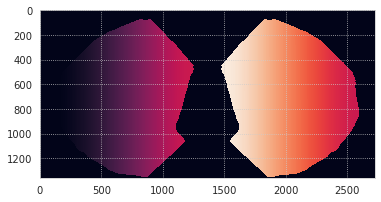

In [52]:
plt.imshow(dorsal_view)